In [17]:
# Shuyi, I think it might be easier to use inline plotting instead of notebook plotting
# It basically means you don't have to use plt.show() in every cell
# Just an idea...
%matplotlib inline

# Plotting data with matplotlib and seaborn

Your ability to understand and communicate data is often entirely dependent on your ability to make a visual representation of that data. The most widely used python libraries for plotting scientific data are `matplotlib` and `seaborn`. 

In today's class we will explore the wide range of python plotting options. We will:

 - Compare samples to get a visual readout of variability
 - Identify a gene that is differentially expressed in metastatic vs normal
 - Generate focused plots looking at that gene's expression

First, we need to import `pyplot` and `seaborn`. While we're at it let's import `numpy` and `pandas` to store and manipulate data prior to plotting. 

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

Import the melanoma data we used in the prior class using pd.read_csv() and pd.read_excel(). 

The data is tab separated and the first column has the gene names.
 
Remember that most things in python are zero-indexed, so the first column is index 0.

In [19]:
#Import the data and show the first five rows of each DataFrame
df = pd.read_csv('GSE88741-expression.txt', sep='\t', index_col=0)

# Take a random sample of 100 genes from the DataFrame
# Again, we're setting the random state so we all get the same random set
df_sample = df.sample(100, axis = 0, random_state = 333)

# Get the metadata from the Excel spreadsheet
meta = pd.read_excel("GSE88741-metadata.xlsx", index_col=1)

# Print the head of each
print (df_sample.head())
print (meta.head())

             GSM2344965  GSM2344966  GSM2344967  GSM2344968  GSM2344969  \
gene_symbol                                                               
ASPDH                 1           1           1           4           0   
KRT18P19              0           0           0           1           0   
ANKIB1             2578        2432        2067        2634        3238   
AGGF1P6               0           0           0           0           0   
ZNF618             1489        1441        1089         997        1088   

             GSM2344970  GSM2344971  GSM2344972  GSM2344973  GSM2344974  \
gene_symbol                                                               
ASPDH                 1           2           1           1           2   
KRT18P19              0           2           1           2           0   
ANKIB1             3158        2373        1908        2324        2918   
AGGF1P6               0           0           0           0           2   
ZNF618              994 

In [20]:
# Assign the sample titles to the columns in the data frame with the expression values
columns = meta.index
df_sample.columns = columns

# We want to look at the log2-transformed data values. To do this without getting negative infinity values, 
# we will nudge the values that have 0 counts to be 0.01.
dfnz = df_sample
dfnz[dfnz == 0] = 0.01
print(dfnz.head())

# Do the log2 transform
df_log2 = dfnz.transform(np.log2)
print(df_log2.head())

Sample Title     FM_1     FM_2     FM_3  SK_MEL_28_1  SK_MEL_28_2  \
gene_symbol                                                         
ASPDH            1.00     1.00     1.00         4.00         0.01   
KRT18P19         0.01     0.01     0.01         1.00         0.01   
ANKIB1        2578.00  2432.00  2067.00      2634.00      3238.00   
AGGF1P6          0.01     0.01     0.01         0.01         0.01   
ZNF618        1489.00  1441.00  1089.00       997.00      1088.00   

Sample Title  SK_MEL_28_3  SK_MEL_147_1  SK_MEL_147_2  SK_MEL_147_3  \
gene_symbol                                                           
ASPDH                1.00          2.00          1.00          1.00   
KRT18P19             0.01          2.00          1.00          2.00   
ANKIB1            3158.00       2373.00       1908.00       2324.00   
AGGF1P6              0.01          0.01          0.01          0.01   
ZNF618             994.00       1947.00       1521.00       1617.00   

Sample Title  UACC

### Relational Plots

We mentioned in an earlier class that `pandas` is built on top of `numpy` to provide easier syntax, easier to read code, and more visually appealing tables. Similarly, `seaborn` is a wrapper around `matplotlib` that makes a fairly complex but powerful library more accessible. We will be showing you both at the same time, as we think `seaborn` is easier to learn and use.  

Scatter plots or line plots are useful for showing the relationship between two variables. Let's start by comparing two replicate samples, FM_1 and FM_2 across all genes in our log2 transformed sampleset.

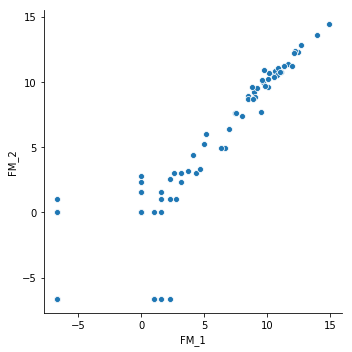

In [21]:
g = sns.relplot(x="FM_1", y="FM_2", data=df_log2)
plt.show()

In [22]:
g

So, right off the bat we are mixing `sns` and `plt`. In the first line of code we are calling the sns function `relplot`, which defaults to a scatterplot. You can also use `relplot` to show lines with confidence intervals (give it a try). 

Notice that we assign the plot to a variable, and then use plt.show from `matplotlib` to print the plot. This is one of several ways to print plots. You will also often see code blocks that simply end with a plotting function, which has a similar output.

When you make a plot using `plt` or `sns` you can build it element by element. Let's repeat the plot from above, but add lines using the `plt.plot` that show the cutoff for a two-fold change. Since our data is in log2, we simply need lines one step out from the identity line (y=x).

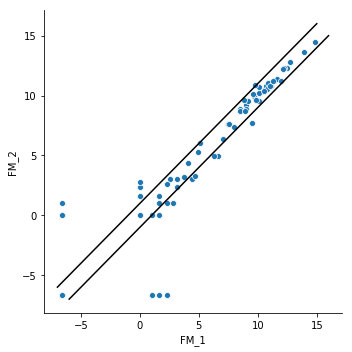

In [23]:
g = sns.relplot(x="FM_1", y="FM_2", data=df_log2)
plt.plot([-7,15],[-6,16],'k')
plt.plot([-6,16],[-7,15],'k')
plt.show()

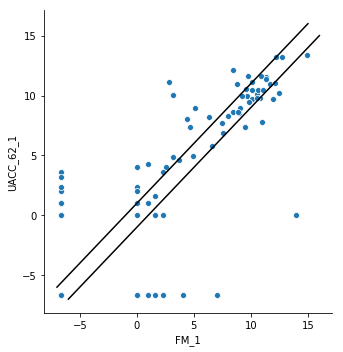

In [24]:
# Now use the same code from above, but compare FM_1 to the metastatic cell line UACC_62_1
g = sns.relplot(x="FM_1", y="UACC_62_1", data=df_log2)
plt.plot([-7,15],[-6,16],'k')
plt.plot([-6,16],[-7,15],'k')
plt.show()

### Categorical Plots

Remember that all of the libraries we have introduced expect each column to be a different variable and each row a different observation.

The dataset we're using consists of four different cell cell lines with three replicates of each. When comparing the samples to each other it makes sense to have the samples as the variable columns and have each gene be an 'observation' of how similar the samples are, gene by gene.

Now we want to look at the genes as variables, so we first transpose the data. We also want to add categorical data for each sample so we can group or color by the 'Stage' or 'SampleName' variables. 

In [25]:
# First, we need to reshape the data frame to be amenable to categorical plots. Seaborn prefers plotting by columns, 
# so the variables of interest should be in the columns, and the different samples/replicates should be in the rows.
# We want to look at gene expression based on a phenotype. So we should also add a column with the phenotype information

# Transpose the data frame so that the genes are in the columns.
dfT = df_log2.T

# Add the phenotype and sample ID information from the "meta" data frame
dfT['Stage'] = meta.Stage
dfT['SampleName'] = dfT.index.str[:-2]

dfT.head()

gene_symbol,ASPDH,KRT18P19,ANKIB1,AGGF1P6,ZNF618,IMPG2,SLC26A6,RP11-28P17.3,CYP51A1P2,UBE3AP2,...,KISS1,AEBP1,EHF,LUM,PLEKHM3,IQCG,AQP7P4,IGLV1-41,Stage,SampleName
Sample Title,,,,,,,,,,,,,,,,,,,,,
FM_1,0.000000,-6.643856,11.332037,-6.643856,10.540128,3.700440,10.112440,-6.643856,1.000000,0.000000,...,-6.643856,13.934520,-6.643856,2.807355,9.832890,8.011227,-6.643856,1.000000,primary melanocytes,FM
FM_2,0.000000,-6.643856,11.247928,-6.643856,10.492855,3.169925,9.575539,-6.643856,-6.643856,1.584963,...,-6.643856,13.626394,-6.643856,1.000000,9.652845,7.366322,-6.643856,-6.643856,primary melanocytes,FM
FM_3,0.000000,-6.643856,11.013323,-6.643856,10.088788,3.906891,10.558421,1.000000,2.321928,0.000000,...,-6.643856,14.614135,0.000000,10.437752,9.231221,7.499846,-6.643856,-6.643856,primary melanocytes,FM
SK_MEL_28_1,2.000000,0.000000,11.363040,-6.643856,9.961450,2.000000,9.816984,-6.643856,1.584963,2.000000,...,-6.643856,0.000000,0.000000,10.726218,9.224002,6.870365,-6.643856,-6.643856,metastatic,SK_MEL_28
SK_MEL_28_2,-6.643856,-6.643856,11.660887,-6.643856,10.087463,1.000000,10.142107,-6.643856,1.584963,0.000000,...,-6.643856,1.584963,2.584963,11.088788,9.335390,7.348728,-6.643856,-6.643856,metastatic,SK_MEL_28


Before we move on to gene comparisons, let's do one last sample comparison, now with the replicates averaged together. We do this with the `pandas` groupby and mean commands, followed by re-transposing the DataFrame so the samples are again columns. 

The `sns` function `pairplot` shows a scatter plot of every pairwise combination of variables. Let's use it to compare each pair of cell lines.

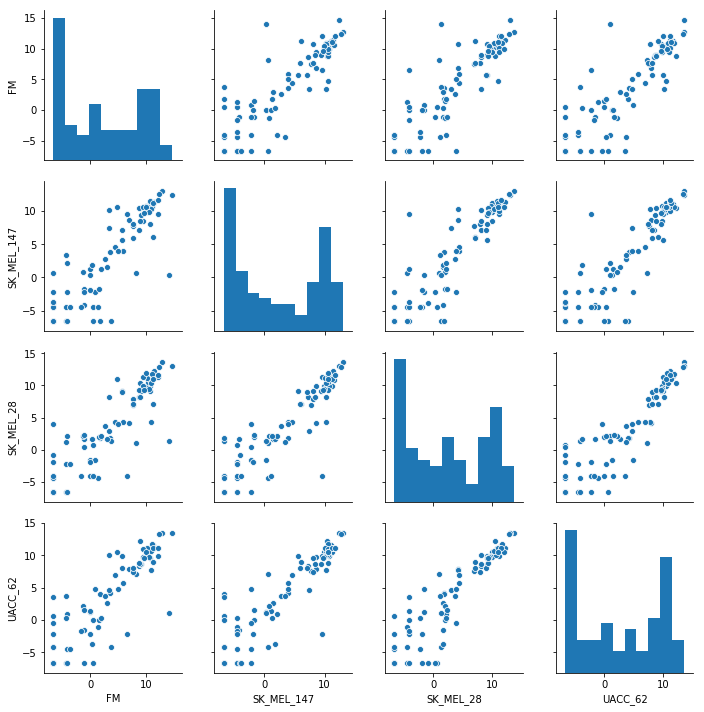

In [26]:
df_group = dfT.groupby('SampleName').mean()
df_group = df_group.T
sns.pairplot(df_group)

Now that the data frame is properly organized, we want to find a gene of interest to focus on in our plots. To do this, we'll calculate the gene with the maximum difference between normal and cancer cells. Let's take a look at the metadata to remind ourselves how the data is structured.

In [27]:
print(meta)

             Sample_geo_accession                Stage           cell type
Sample Title                                                              
FM_1                   GSM2344965  primary melanocytes  normal melanocytes
FM_2                   GSM2344966  primary melanocytes  normal melanocytes
FM_3                   GSM2344967  primary melanocytes  normal melanocytes
SK_MEL_28_1            GSM2344968           metastatic  melanoma cell line
SK_MEL_28_2            GSM2344969           metastatic  melanoma cell line
SK_MEL_28_3            GSM2344970           metastatic  melanoma cell line
SK_MEL_147_1           GSM2344971           metastatic  melanoma cell line
SK_MEL_147_2           GSM2344972           metastatic  melanoma cell line
SK_MEL_147_3           GSM2344973           metastatic  melanoma cell line
UACC_62_1              GSM2344974           metastatic  melanoma cell line
UACC_62_2              GSM2344975           metastatic  melanoma cell line
UACC_62_3              GS

In [28]:
# To do this, we start by creating separate data frames for the Normal and the Metastatic samples.

#slicing out the normal and metastatic samples
FMnorm = df_log2.iloc[:,0:3]
Metastatic = df_log2.iloc[:,3:]

print(FMnorm.head())
print(Metastatic.head())

Sample Title       FM_1       FM_2       FM_3
gene_symbol                                  
ASPDH          0.000000   0.000000   0.000000
KRT18P19      -6.643856  -6.643856  -6.643856
ANKIB1        11.332037  11.247928  11.013323
AGGF1P6       -6.643856  -6.643856  -6.643856
ZNF618        10.540128  10.492855  10.088788
Sample Title  SK_MEL_28_1  SK_MEL_28_2  SK_MEL_28_3  SK_MEL_147_1  \
gene_symbol                                                         
ASPDH            2.000000    -6.643856     0.000000      1.000000   
KRT18P19         0.000000    -6.643856    -6.643856      1.000000   
ANKIB1          11.363040    11.660887    11.624795     11.212496   
AGGF1P6         -6.643856    -6.643856    -6.643856     -6.643856   
ZNF618           9.961450    10.087463     9.957102     10.927037   

Sample Title  SK_MEL_147_2  SK_MEL_147_3  UACC_62_1  UACC_62_2  UACC_62_3  
gene_symbol                                                                
ASPDH             0.000000      0.000000  

In [29]:
# Then calculating the means of each type
FMmean = FMnorm.mean(1)
MetastaticMean = Metastatic.mean(1)

# Calculating the difference of the means
MeanDiff = FMmean - MetastaticMean

# Finding the max and the minimum means
maxDiffGene = MeanDiff.idxmax()
minDiffGene = MeanDiff.idxmin()

print(MeanDiff.sort_values())

gene_symbol
EHF              -7.203594
AC104073.1       -7.088185
FOXC1            -6.114591
LUM              -5.966445
APOF             -5.871157
AC010731.4       -4.242528
KRT18P19         -4.024365
ZNF676           -2.954035
AC243945.1       -2.824825
DGKI             -2.543371
AGGF1P6          -2.436841
CHRNA7           -2.420790
SLC10A1          -2.325730
PRELID2P1        -2.325730
HNRNPA1P29       -2.214619
DYNLT3           -2.186492
AC064850.4       -1.840963
KISS1            -1.809746
RPS6KA6          -1.625172
RECQL4           -1.579509
DTX3L            -1.125415
SULT1A1          -0.877127
AQP7P4           -0.849317
ZNF343           -0.771921
NCMAP            -0.757974
RP11-25J3.2      -0.738206
RP11-11A5.1      -0.738206
RCC2             -0.655997
SHMT1            -0.655026
BCAP31           -0.634210
                   ...    
DYNC2H1           0.462046
TNNC1             0.486758
NBPF17P           0.513305
IQCG              0.555745
RP11-113C12.2     0.564805
ZNF24           

In [30]:
print(maxDiffGene) #Note that gene of interest will be "AEBP1"
print(FMnorm.loc[maxDiffGene])
print(Metastatic.loc[maxDiffGene])

AEBP1
Sample Title
FM_1    13.934520
FM_2    13.626394
FM_3    14.614135
Name: AEBP1, dtype: float64
Sample Title
SK_MEL_28_1     0.000000
SK_MEL_28_2     1.584963
SK_MEL_28_3     2.321928
SK_MEL_147_1    1.000000
SK_MEL_147_2    0.000000
SK_MEL_147_3    0.000000
UACC_62_1       0.000000
UACC_62_2       1.584963
UACC_62_3       1.584963
Name: AEBP1, dtype: float64


There are many ways to plot categorical data like bar, box and whisker, swarm plots. Let's look at the expression of AEBP1 using each of these methods. There are separate methods for each, but they are pulled together for convenience in one function, `catplot`. 

In [ ]:
# Starting off with a bar plot
g = sns.catplot(x = 'Stage',y='AEBP1', data=dfT, kind="bar")
plt.show()
# Note that the error bars are plotted by default

In [ ]:
g = sns.catplot(x = 'Stage',y='AEBP1', data=dfT, kind="box")
plt.show()

In [ ]:
g = sns.catplot(x = 'Stage',y = 'AEBP1', data=dfT, kind="swarm")
plt.show()

We can add a third, fourth, or fifth dimension of categorical data by changing the color, shape, or size of the markers. Let's set the hue by 'SampleName'.

In [ ]:
g = sns.catplot(x = 'Stage',y = 'AEBP1',hue = 'SampleName', data=dfT, kind="swarm")
plt.show()

You can also plot multiple overlapping plots to 

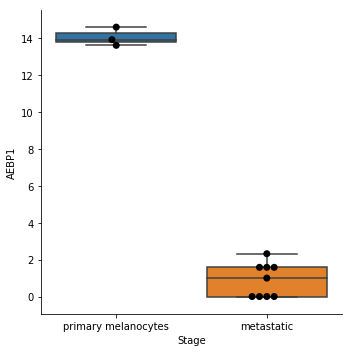

In [31]:
g = sns.catplot(x="Stage", y="AEBP1", kind="box", data=dfT)
sns.swarmplot(x="Stage", y="AEBP1", color="k", size=7, data=dfT, ax=g.ax);